# **Modules**

In [1]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import datetime
import numpy as np
import pandas as pd

import copy
import math

import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('figure', figsize=(12, 3))
import optuna
from typing import Literal, Tuple

from IPython.display import display, clear_output

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-2o5ujrtf because the default path (/home/upbeat_liskov/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# **Config**

In [2]:
# !!! Run first data_generation.ipynb to generate these files from the main data csv stored in drive !!! 
train_path = './data/train_per_hour.csv'
val_path = './data/val_per_hour.csv'
test_path = './data/test_per_hour.csv'

In [46]:
# Fixed parameters
## Missing ratio for masked values
missing_ratio = 0.4
## Default value to replace the nan before being feeded to NN
val_spec = 0
## Each sample is a subsequence of length 48 (2days)
seq_length = 48
## Random seed
random_state = 42
torch.manual_seed(random_state)
torch.set_default_dtype(torch.float64)

In [4]:
# Common Hyperparameters for models
## Batch and epochs size
batch_size = 32
epochs = 50
## Dropout probability
dropout=0.5
## Learning rate
learning_rate = 0.001

In [5]:
# List of statistical methods covered
class_methods = ['mean','median','mode','LOCF','NOCB','linear_interpolation','spline_interpolation','knn','mice']

# **Data preprocessing**

In [6]:
def preprocess_data(train_path:str,val_path:str,test_path:str,scaler:callable)->Tuple[pd.DataFrame,pd.DataFrame,pd.DataFrame]:
    """
    Preprocess Data
    :param train_path: Path to train data
    :param val_path: Path to validation data
    :param test_path: Path to test data
    :param scaler: Scaler to use
    :return: Preprocessed train, validation and test data
    """
    # Read Data
    train = pd.read_csv(train_path)
    val = pd.read_csv(val_path)
    test = pd.read_csv(test_path)
    # Drop Date Column
    if 'Date' in train.columns:
        train.drop(['Date'],axis=1,inplace=True)
        val.drop(['Date'],axis=1,inplace=True)
        test.drop(['Date'],axis=1,inplace=True)    
    # Scale Data
    train = pd.DataFrame(scaler.fit_transform(train),columns=train.columns)
    val = pd.DataFrame(scaler.transform(val),columns=val.columns)
    test = pd.DataFrame(scaler.transform(test),columns=test.columns)
    return train,val, test

In [7]:
def generate_MCAR_nans(df:pd.DataFrame, missing_ratio:int,random_state:int)->Tuple[pd.DataFrame,np.ndarray]:
    """
    Generate Missing values in MCAR way
    :param df: Dataframe to be masked
    :param missing_ratio: Missing ratio per each feature
    :param random_state: Random state
    :return: Dataframe with missing values and mask
    """
    np.random.seed(random_state)
    df_nan = df.mask(np.random.random(df.shape) < missing_ratio,inplace=False)
    mask = np.isnan(df_nan.values).astype(int)
    return df_nan, mask

In [8]:
train,val, test = preprocess_data(train_path,val_path,test_path,MinMaxScaler()) 

In [9]:
test_nan, test_mask =generate_MCAR_nans(test,missing_ratio,random_state)

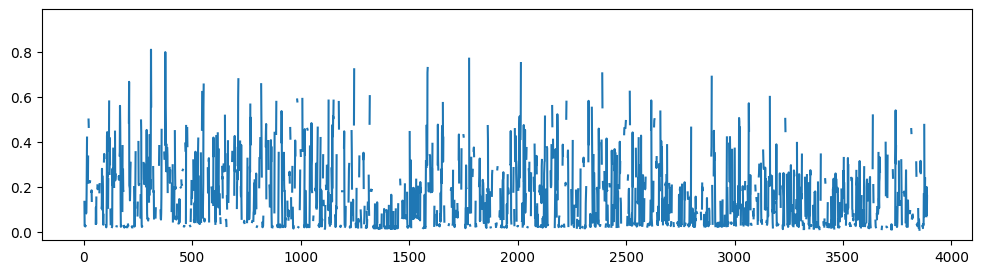

In [91]:
plt.plot(test_nan.Global_intensity)
plt.show()

# **Performance Evaluation Utils**

In [11]:
def evaluate_imputation_mse(df: pd.DataFrame, df_imputed: pd.DataFrame, mask: np.ndarray,method_title: str)->pd.DataFrame:
    """
    Evaluate the imputation performance by calculating the mean squared error (MSE) between the imputed and the original data.
    :param df: original data
    :param df_imputed: imputed data
    :param mask: mask of the missing values
    :param method_title: title of the imputation method
    :return: pd.DataFrame with the MSE
    """
    mse_per_column =  np.sum((df*mask - df_imputed*mask)**2)/np.sum(mask, axis=0)
    print('--------------------')
    print('For ', method_title, ' the mse per column is: ')
    print(mse_per_column)
    print('mse_mean ', mse_per_column.mean())
    result = pd.DataFrame({'method':method_title,'mse':mse_per_column.mean(),'var':mse_per_column.var()},index = [0])
    return result

In [12]:
def t_test(df: pd.DataFrame,df_imputed: pd.DataFrame, mask: np.ndarray, method_title: str)->pd.DataFrame:
    """
    T-test for the imputed data and the original data
    :param df: original data
    :param df_imputed: imputed data
    :param mask: mask for the original data
    :param method_title: title of the imputation method
    :return: a dataframe with the p-value of the t-test for each column
    """
    df_imputed = df_imputed * mask + df *(1 - mask)
    ttest = stats.ttest_ind(df.values, df_imputed.values)
    test_stat = pd.DataFrame(columns=['method','column','p-value','same_distribution']) 
    for n in range(len(ttest.pvalue)): 
        test_stat.loc[n] = [method_title,df.columns[n], ttest.pvalue[n],ttest.pvalue[n]<0.05 ]                   
    return test_stat

In [13]:
def evaluate_set(list_methods: list,test: pd.DataFrame,test_nan: pd.DataFrame,test_mask: np.ndarray)->Tuple[pd.DataFrame,pd.DataFrame]:
    """
    Evaluate the imputation methods on the test set
    :param list_methods: list of imputation methods
    :param test: test set
    :param test_nan: test set with missing values
    :param test_mask: mask of missing values
    :return: a tuple of two dataframes, the first one contains the mse of each imputation method, the second one contains the t-test results
    """
    evals = pd.DataFrame()
    tests = pd.DataFrame()
    for strat in list_methods:
        df_imputed = classical_imputer(test_nan,strat)
        evals = pd.concat([evals,evaluate_imputation_mse(test,df_imputed,test_mask, strat)])
        tests = pd.concat([tests,t_test(test,df_imputed,test_mask,strat)])
    evals.sort_values(by=["mse"], inplace = True)
    evals.reset_index(drop=True, inplace=True)
    return evals,tests

# **Classical Imputation Methods**

In [14]:
def classical_imputer(test: pd.DataFrame,strategy: 
    Literal['mean','median','mode','LOCF','NOCB','linear_interpolation','spline_interpolation','knn','mice'],
    spline_order = 3,
    random_state = random_state,
    n_neighbors = 5)->pd.DataFrame:
    """
    Impute missing values using classical imputation methods
    :param test: Dataframe to impute
    :param strategy: Imputation strategy
    :param spline_order: Order of spline interpolation
    :param random_state: Random state for mice imputation
    :param n_neighbors: Number of neighbors for knn imputation
    :return: Imputed dataframe
    """
    try:
        df = test.copy()
        df_imputed = None
        if strategy == 'mean':
            mean_imp = SimpleImputer(strategy='mean')
            df_imputed = pd.DataFrame(mean_imp.fit_transform(df),columns=df.columns)
        elif strategy == 'median':
            median_imp = SimpleImputer(strategy='median')
            df_imputed = pd.DataFrame(median_imp.fit_transform(df),columns=df.columns)
        elif strategy == 'mode':
            most_frequent_imp = SimpleImputer(strategy='most_frequent')
            df_imputed =  pd.DataFrame(most_frequent_imp.fit_transform(df), columns=df.columns)
        elif strategy == 'LOCF':
            df_imputed = df.fillna(method='ffill').fillna(method='bfill')
        elif strategy == 'NOCB':
            df_imputed = df.fillna(method='bfill').fillna(method='ffill')
        elif strategy == 'linear_interpolation':
            df_imputed = df.interpolate(method='linear',limit_direction='both')
        elif strategy == 'spline_interpolation':
            df_imputed = df.interpolate(method='spline',order=spline_order,limit_direction='both')
        elif strategy == 'knn':
            knn_imp = KNNImputer(n_neighbors=n_neighbors)
            df_imputed = pd.DataFrame(knn_imp.fit_transform(df),columns=df.columns)
        elif strategy == 'mice':
            mice_imp = IterativeImputer(random_state=random_state)
            df_imputed = pd.DataFrame(mice_imp.fit_transform(df),columns=df.columns)
        else:
            raise ValueError("Error : The strategy '{}' is not supported".format(strategy))
        return df_imputed
    except ValueError as e:
        raise(e)

# **DataSet and DataLoaders for DL models**

In [15]:
def random_mask_tensor(tensor:torch.Tensor, missing_ratio:float, seed:int, val_spec=val_spec)->Tuple[torch.Tensor,torch.Tensor]:
    """
    Randomly masks a tensor with a given missing ratio.
    :param tensor: the tensor to be masked
    :param missing_ratio: The ratio of values to be masked
    :return: the masked tensor and the mask tensor
    """
    # Calculate the number of values to mask
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    num_masked_values = int(tensor.numel() * missing_ratio)
    # Create a mask tensor with the same shape as the input tensor
    mask = torch.ones_like(tensor)
    # Randomly select values to be masked and set their corresponding mask tensor values to 0
    mask_indices = torch.randperm(tensor.numel())[:num_masked_values]
    mask = mask.flatten()
    mask[mask_indices] = 0
    mask = mask.reshape(tensor.shape)
    mask = 1 - mask 
    mask = mask.bool() 
    # Mask the input tensor
    masked_tensor = tensor.masked_fill(mask, val_spec)
    # Return the masked tensor and the mask tensor
    return masked_tensor, mask

In [16]:
class TSImputationTrainDataset(Dataset):
    """Time series imputation dataset for training"""
    def __init__(self, df, seq_length,missing_ratio):
        self.data = torch.tensor(df.values,dtype=torch.float64)
        self.seq_length = seq_length
        self.missing_ratio = missing_ratio 
            
    def __len__(self):
        return len(self.data) - self.seq_length + 1

    def __getitem__(self, index):
        assert(len(self.data)>=self.seq_length)
        # Get a sequence of data of length seq_length
        target = self.data[index:index+self.seq_length]
        # generate masked input and the mask
        masked_input, mask = random_mask_tensor(target,self.missing_ratio,index)
        return target, masked_input, mask

In [17]:
class TSImputationEvalDataset(Dataset):
    """Time series imputation dataset for testing"""
    def __init__(self, df, df_nan, mask, seq_length):
        self.seq_length = seq_length
        self.data = torch.tensor(df.values,dtype=torch.float64)
        self.data_nan = torch.tensor(df_nan.values,dtype=torch.float64)
        self.mask = torch.tensor(mask,dtype=torch.bool)
        
    def __len__(self):
        if len(self.data) >= self.seq_length:
            return len(self.data) - self.seq_length + 1
        return 1
    
    def __getitem__(self, index):
        # Get a sequence of data of length seq_length or less
        start = index
        end = index + self.seq_length
        target = self.data[start:end]
        masked_input = self.data_nan[start:end]
        mask = self.mask[start:end]
        # add padding if needed
        if end > len(self.data):
            padding = torch.zeros(self.seq_length - len(target), self.data.shape[1])
            target = torch.cat([target, padding], dim=0)
            masked_input = torch.cat([masked_input,padding], dim=0)
            mask = torch.cat([mask,padding.bool()], dim=0)
        masked_input[torch.isnan(masked_input)] = 0
        return target, masked_input, mask

In [18]:
train_dataset = TSImputationTrainDataset(train,seq_length,missing_ratio)
val_dataset = TSImputationTrainDataset(val,seq_length,missing_ratio)
test_dataset = TSImputationEvalDataset(test,test_nan,test_mask,seq_length)

In [19]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [20]:
print('total training batch number: {}'.format(len(train_loader)))
print('total validation batch number: {}'.format(len(val_loader)))
print('total test batch number: {}'.format(len(test_loader)))

total training batch number: 225
total validation batch number: 56
total test batch number: 3853


# **DL models**

## **Utils**

In [21]:
class ORT_MIT_Loss(nn.Module):
    """ Masked Imputation Task (MIT)
        Observed Reconstruction Task (ORT) 
    """
    def __init__(self,delta = 0.5):
        super().__init__()
        self.delta = delta

    def forward(self,y_pred: torch.Tensor, y_true: torch.Tensor, mask: torch.BoolTensor) -> torch.Tensor:
        MIT = torch.sum(torch.square(y_pred - y_true) * mask) / (torch.sum(mask))
        ORT = torch.sum(torch.square(y_pred - y_true) * ~mask) / (torch.sum(~mask))
        return ORT + self.delta*MIT

In [22]:
class MaskedMSELoss(nn.Module):
    """ Masked MSE Loss
    """
    def __init__(self, reduction: str = 'mean'):
        super().__init__()
        self.reduction = reduction
        self.mse_loss = nn.MSELoss(reduction=self.reduction)

    def forward(self,
                y_pred: torch.Tensor, y_true: torch.Tensor, mask: torch.BoolTensor) -> torch.Tensor:
        """Compute the loss between a target value and a prediction.
        Args:
            y_pred: Estimated values
            y_true: Target values
            mask: boolean tensor with 0s at places where values should be ignored and 1s where they should be considered
        Returns
        -------
        if reduction == 'none':
            (num_active,) Loss for each active batch element as a tensor with gradient attached.
        if reduction == 'mean':
            scalar mean loss over batch as a tensor with gradient attached.
        """

        # for this particular loss, one may also elementwise multiply y_pred and y_true with the inverted mask
        masked_pred = torch.masked_select(y_pred, mask)
        masked_true = torch.masked_select(y_true, mask)

        return self.mse_loss(masked_pred, masked_true)

In [23]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

In [24]:
class HuberLossWithMask(nn.Module):
    def __init__(self, delta=1.0):
        super(HuberLossWithMask, self).__init__()
        self.delta = delta

    def forward(self, y_true, y_pred, mask):
        error = y_true - y_pred
        abs_error = torch.abs(error)
        quadratic = torch.clamp(abs_error, max=self.delta)
        linear = abs_error - quadratic
        loss = 0.5 * quadratic ** 2 + self.delta * linear
        masked_loss = loss * mask.float()
        return masked_loss.mean()

In [25]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)]) 

In [26]:
def count_parameters(model):
    nb_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('This model has ',nb_params , ' parameter')
    return nb_params

In [27]:
def load_model(model,model_path):
    model.load_state_dict(torch.load(model_path)['model_state_dict'])
    model.eval()
    return model

In [28]:
def padding_tensor(tensor, len_test, number_features, index, is_flatten):
    if is_flatten:
        padding_left = torch.zeros(tensor.shape[0],index*number_features)
        padding_right = torch.zeros(tensor.shape[0], len_test*number_features-tensor.shape[1]-index*number_features)
    else:
        padding_left = torch.zeros(tensor.shape[0],index, number_features)
        padding_right = torch.zeros(tensor.shape[0],len_test-tensor.shape[1]-index, number_features)
    if torch.cuda.is_available():
            padding_left, padding_right = padding_left.cuda(), padding_right.cuda()
    result = torch.cat([padding_left,tensor,padding_right], dim=1)
    return result

In [29]:
def predict(model, test, sequence_length, test_loader, is_flatten = False, is_TS = False ):
    # Init
    test_predicted = []
    test_or = []
    i = 0
    len_test, number_features = test.shape
    # Prediction loop over loader
    for target, masked_input, mask in test_loader:
        if torch.cuda.is_available():
            target, masked_input, mask = target.cuda(), masked_input.cuda(), mask.cuda()
        if is_flatten:
            target = target.view(target.shape[0],target.shape[2]*target.shape[1])
            masked_input = masked_input.view(masked_input.shape[0],masked_input.shape[2]*masked_input.shape[1])
        if is_TS:
            output = model(masked_input,None)
        else:
            output = model(masked_input)
        ## Padding
        test_predicted.append(padding_tensor(output, len_test, number_features, i, is_flatten))
        test_or.append(padding_tensor(target, len_test, number_features, i, is_flatten))  
        i+=1    
    
    # Weighted sum of predictions and target
    test_predicted_final = torch.zeros_like(test_predicted[0])
    for tensor in test_predicted:
        test_predicted_final = torch.add(test_predicted_final, tensor)

    test_or_final = torch.zeros_like(test_or[0])
    for tensor in test_or:
        test_or_final = torch.add(test_or_final, tensor)
        
    test_predicted_temp = torch.zeros_like(test_predicted_final)
    test_or_temp = torch.zeros_like(test_or_final)
    
    for i in range(len_test):
        if is_flatten:
            candidat = test_predicted_final[0][i*number_features:(i+1)*number_features]
            candidat_target = test_or_final[0][i*number_features:(i+1)*number_features]
        else:
            candidat = test_predicted_final[0][i]
            candidat_target = test_or_final[0][i]
        if i<sequence_length:
            change = candidat/(i+1)
            change_target = candidat_target/(i+1)
        elif i>(len_test%sequence_length)*sequence_length:
            change = candidat/(len_test-i)
            change_target = candidat_target/(len_test-i)
        else:
            change = candidat/sequence_length
            change_target = candidat_target/sequence_length
        if is_flatten:
            test_predicted_temp[0][i*number_features:(i+1)*number_features] = change
            test_or_temp[0][i*number_features:(i+1)*number_features] = change_target
        else:
            test_predicted_temp[0][i] = change
            test_or_temp[0][i] = change_target
            
    test_predicted_final = test_predicted_temp
    test_or_final = test_or_temp

    # Reshape
    if is_flatten:
        test_predicted_final=test_predicted_final.view(test.shape[0],test.shape[1])
        test_or_final=test_or_final.view(test.shape[0],test.shape[1])
    else:
        test_predicted_final = torch.reshape(test_predicted_final,(test_predicted_final.shape[0]*test_predicted_final.shape[1],test_predicted_final.shape[2]))
        test_or_final = torch.reshape(test_or_final,(test_or_final.shape[0]*test_or_final.shape[1],test_or_final.shape[2]))
        
    # Final dataframes
    test_predicted_final=pd.DataFrame(test_predicted_final[:len(test)].cpu().detach().numpy(),columns=test.columns)
    test_or_final=pd.DataFrame(test_or_final[:len(test)].cpu().detach().numpy(),columns=test.columns)
    return test_predicted_final, test_or_final

In [30]:
loss_fn = ORT_MIT_Loss(8)

## **MLP AutoEncoder**

In [31]:
class FullyConnectedAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, output_dim):
        super().__init__()
        # Encoder: affine function
        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        # Decoder: affine function
        self.fc3 = nn.Linear(hidden_dim_2, hidden_dim_1)
        self.fc4 = nn.Linear(hidden_dim_1, output_dim)
        

    def forward(self, x):
        # Encoder
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)

        # Decoder
        out = self.fc3(out)
        out = F.relu(out)
        out = self.fc4(out)
        out = torch.sigmoid(out)

        return out

### **Train the AutoEncoder**

In [41]:
# Parameters
## subsequence dimension 7*48
input_dim = train.shape[1] * seq_length
## output dimension
output_dim = input_dim

In [42]:
# Hyperparameters
## This is the parameter finetune for this model
reduction_parameter = 0.8
hidden_dim_1 = int(input_dim * reduction_parameter)
hidden_dim_2 = int(hidden_dim_1 * reduction_parameter)

In [43]:
# Init model and loss function
model_ae = FullyConnectedAutoencoder(input_dim, hidden_dim_1, hidden_dim_2, output_dim)
if torch.cuda.is_available():
    model_ae = model_ae.cuda()

In [44]:
def train_model_AE(model,loss_fn,epochs,train_loader,val_loader, learning_rate=0.001, gamma=0.9):
    """
    Train the autoencoder
    :param model:model of class FullyConnectedAutoencoder
    :param loss_fn: loss function
    :param eopchs: number of epochs
    :param train_loader: train loader
    :param val_loader: validation loader
    :param learning_rate: learning rate
    :param gamma: multiplicative factor of learning rate decay
    """
    #optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)  
    #scheduler = ExponentialLR(optimizer, gamma=gamma)
    model_opt = NoamOpt(input_dim,2, 100,
    torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
    
    train_loss_list = []
    val_loss_list = []
    lr_values=[]
    # train phase
    for epoch in range(epochs):
        # training phase
        train_loss = 0
        model.train()
        for i, (target, masked_input, mask) in enumerate(train_loader):
            target = target.view(target.shape[0],target.shape[2]*target.shape[1])
            masked_input = masked_input.view(masked_input.shape[0],masked_input.shape[2]*masked_input.shape[1])
            mask = mask.view(mask.shape[0],mask.shape[2]*mask.shape[1])
            if torch.cuda.is_available():
                target, masked_input, mask = target.cuda(), masked_input.cuda(), mask.cuda()
            model_opt.optimizer.zero_grad()
            outputs = model(masked_input)
            loss = loss_fn(outputs, target,mask)
            loss.backward()
            model_opt.step()
            lr_values.append(model_opt.optimizer.param_groups[0]['lr'])
            train_loss += loss.item()
        #scheduler.step()
   
        
        # validation phase  
        valid_loss = 0.0
        model.eval() 
        for batch in val_loader:
            x, x_nan, mask = batch
            x = x.view(x.shape[0],x.shape[2]*x.shape[1])
            x_nan = x_nan.view(x_nan.shape[0],x_nan.shape[2]*x_nan.shape[1])
            mask = mask.view(mask.shape[0],mask.shape[2]*mask.shape[1])
            if torch.cuda.is_available():
                x, x_nan, mask = x.cuda(), x_nan.cuda(), mask.cuda()
            outputs = model(x_nan)
            loss = loss_fn(outputs, x,mask)
            valid_loss += loss.item()
        train_loss_list.append(train_loss / len(train_loader))
        val_loss_list.append(valid_loss/len(val_loader))
        print('Epoch {}: train loss: {}, val loss: {}'.format(epoch,train_loss / len(train_loader),valid_loss/len(val_loader)))
    # Saving State Dict
    date_time = datetime.datetime.now()
    index = ('_').join(str(date_time).split(' '))
    PATH = './trained_models/AE_models/model_final_' + index
    torch.save({
    'epoch': epochs,
    'batch_size': batch_size,
    'learning_rate':learning_rate,
    'model_state_dict': model.state_dict(),
    'train_loss': train_loss_list,
    'val_loss':val_loss_list,
     'hidden_dim_1':hidden_dim_1,
     'hidden_dim_2':hidden_dim_2
    }, PATH)
    clear_output()
    return train_loss_list, val_loss_list,PATH,lr_values

In [47]:
LR_MIN=1e-6
LR_CEIL=1
MIN_EPOCHS=20
MAX_EPOCHS=70
MIN_SEQ_LEN=12
MAX_SEQ_LEN=96
BATCH_VALUES=[8,16,32,64]
LOSS_PARAMS_LIST=[0.5,2,2.5,4,6,8]
MIN_DROPOUT=0.1
MAX_DROPOUT=0.8
NUM_TRIALS=50
RP_MIN=0.4
RP_MAX=0.8

def objective(trial: optuna.Trial):     
    learning_rate = trial.suggest_loguniform('learning_rate', low=LR_MIN, high=LR_CEIL)
    reduction_param = trial.suggest_discrete_uniform('reduction_param', low=RP_MIN, high=RP_MAX,q=0.1)
    num_train_epochs = trial.suggest_discrete_uniform('num_train_epochs', low=MIN_EPOCHS, high=MAX_EPOCHS,q=10)
    sequence_length = trial.suggest_discrete_uniform('sequence_length', MIN_SEQ_LEN, MAX_SEQ_LEN,q=12)
    batch_size = trial.suggest_categorical('batch_size', BATCH_VALUES)
    loss_parameter = trial.suggest_categorical('loss_parameter', LOSS_PARAMS_LIST)
    dropout = trial.suggest_discrete_uniform('dropout', MIN_DROPOUT, MAX_DROPOUT,q=0.1)  
    
    sequence_length=int(sequence_length)
    input_dim = train.shape[1] * sequence_length
    hidden_dim_1 = int(input_dim * reduction_parameter)
    hidden_dim_2 = int(hidden_dim_1 * reduction_parameter)
    output_dim = input_dim
    batch_size=int(batch_size)
    num_train_epochs=int(num_train_epochs)
    
    print('sequence_length',sequence_length,'batch_size',batch_size,'num_train_epochs',num_train_epochs)
    print('input_dim',input_dim,'hidden_dim_1',hidden_dim_1,'hidden_dim_2',hidden_dim_2,'reduction_param',reduction_param)
    model_ae = FullyConnectedAutoencoder(input_dim, hidden_dim_1, hidden_dim_2, output_dim)
    train_dataset = TSImputationTrainDataset(train,sequence_length,missing_ratio)
    val_dataset = TSImputationTrainDataset(val,sequence_length,missing_ratio)
    test_dataset = TSImputationEvalDataset(test,test_nan,test_mask,sequence_length)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    print('total training batch number: {}'.format(len(train_loader)))
    print('total validation batch number: {}'.format(len(val_loader)))
    print('total test batch number: {}'.format(len(test_loader)))
    if torch.cuda.is_available():
        model_ae = model_ae.cuda()
    loss_fn = ORT_MIT_Loss(loss_parameter)
    
    train_loss_list, val_loss_list, model_ae_PATH, lr_values = train_model_AE(model_ae, loss_fn, num_train_epochs, train_loader, val_loader, learning_rate, gamma=0.9)
         
    return train_loss_list[-1]

study = optuna.create_study(study_name='deepl_finetune', direction='minimize') 
study.optimize(func=objective, n_trials=NUM_TRIALS)  

print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial
print('  Value: {:.5f}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))


[I 2023-03-29 10:58:35,327] Trial 49 finished with value: 0.0685149036650059 and parameters: {'learning_rate': 0.054566468558862075, 'reduction_param': 0.4, 'num_train_epochs': 60.0, 'sequence_length': 24.0, 'batch_size': 32, 'loss_parameter': 6, 'dropout': 0.2}. Best is trial 40 with value: 0.01259040014662406.


Number of finished trials: 50
Best trial:
  Value: 0.01259
  Params: 
    learning_rate: 0.2607884316102392
    reduction_param: 0.5
    num_train_epochs: 70.0
    sequence_length: 24.0
    batch_size: 32
    loss_parameter: 0.5
    dropout: 0.8


In [48]:
#train_loss_list, val_loss_list,model_ae_PATH,lr_values = train_model_AE(model_ae,loss_fn,epochs,train_loader,val_loader, gamma=0.9)
#df = pd.DataFrame({'epochs':[i for i in range(epochs)],'train_loss': train_loss_list,'val_loss': val_loss_list})
#df.plot(x="epochs", y=["train_loss", "val_loss"],kind="line")

# **ConvAE**

In [74]:
class ConvAutoencoder(nn.Module):
    def __init__(self,T,D,hidden_dim1,hidden_dim2,hidden_dim3,in_channels=1,out_channels_1=16,out_channels_2=8):
        super(ConvAutoencoder, self).__init__()
        self.T = T
        self.D = D
        ## Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels_1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels_1, out_channels=out_channels_2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(out_channels_2 * T * D, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.ReLU()
        )

        ## Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim3, hidden_dim2),
            nn.ReLU(),            
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, out_channels_2 * T * D),
            nn.ReLU(),
            nn.Unflatten(dim=1,unflattened_size=(out_channels_2, T, D)),
            nn.ConvTranspose2d(in_channels=out_channels_2, out_channels=out_channels_1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=out_channels_1, out_channels=in_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1,1)),
            nn.Sigmoid()
        )
    
        
    def forward(self, x):
        x = x.unsqueeze(1)  # add a channel dimension to the input (N, T, D) -> (N, 1, T, D)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.squeeze(1)  # remove the channel dimension from the output (N, 1, T, D) -> (N, T, D)
        return x

In [75]:
# Parameters
d_input = train.shape[1]
input_dim = train.shape[1] * seq_length

In [76]:
# Hyperparameters
reduction_parameter = 0.6
hidden_dim1 = int(input_dim * reduction_parameter)
hidden_dim2 = int(hidden_dim_1 * reduction_parameter)
hidden_dim3 = int(hidden_dim_2 * reduction_parameter)

In [77]:
#init model
model_conv_ae = ConvAutoencoder(seq_length,d_input,hidden_dim1, hidden_dim2,hidden_dim3)
if torch.cuda.is_available():
    model_conv_ae = model_conv_ae.cuda()


In [78]:
def train_model_Conv_AE(model,loss_fn,epochs,train_loader,val_loader, learning_rate=learning_rate, gamma=0.9):
    optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)  
    scheduler = ExponentialLR(optimizer, gamma=gamma)
    train_loss_list = []
    val_loss_list = []
   
    for epoch in range(epochs):
        # train phase
        train_loss = 0
        model.train()
        for i, (target, masked_input, mask) in enumerate(train_loader):
            if torch.cuda.is_available():
                target, masked_input, mask = target.cuda(), masked_input.cuda(), mask.cuda()
            optimizer.zero_grad()
            outputs = model(masked_input)
            loss = loss_fn(outputs, target,mask)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        scheduler.step()
        
        # validation phase
        valid_loss = 0.0
        model.eval() 
        with torch.no_grad():
            for batch in val_loader:
                x, x_nan, mask = batch
                if torch.cuda.is_available():
                    x, x_nan, mask = x.cuda(), x_nan.cuda(), mask.cuda()
                outputs = model(x_nan)
                loss = loss_fn(outputs, x,mask)
                valid_loss += loss.item()
        train_loss_list.append(train_loss / len(train_loader))
        val_loss_list.append(valid_loss/len(val_loader))
        print('Epoch {}: train loss: {}, val loss: {}'.format(epoch,train_loss / len(train_loader),valid_loss/len(val_loader)))
    # Saving State Dict
    date_time = datetime.datetime.now()
    index = ('_').join(str(date_time).split(' '))
    PATH = './trained_models/CONV_AE_models/model_final_' + index
    torch.save({
    'epoch': epochs,
    'batch_size': batch_size,
    'learning_rate':learning_rate,
    'hidden_dim_1':hidden_dim_1,
    'hidden_dim_2':hidden_dim_2,
    'missing_ratio': missing_ratio,
    'model_state_dict': model.state_dict(),
    'train_loss': train_loss_list,
    'val_loss':val_loss_list
    }, PATH)
    clear_output()
    return train_loss_list, val_loss_list,PATH

In [93]:
NUM_TRIALS=30
def objective(trial: optuna.Trial):     
    learning_rate = trial.suggest_loguniform('learning_rate', low=LR_MIN, high=LR_CEIL)
    reduction_parameter = trial.suggest_discrete_uniform('reduction_parameter', low=RP_MIN, high=RP_MAX,q=0.1)
    num_train_epochs = trial.suggest_discrete_uniform('num_train_epochs', low=MIN_EPOCHS, high=MAX_EPOCHS,q=10)
    sequence_length = trial.suggest_discrete_uniform('sequence_length', MIN_SEQ_LEN, MAX_SEQ_LEN,q=12)
    batch_size = trial.suggest_categorical('batch_size', BATCH_VALUES)
    loss_parameter = trial.suggest_categorical('loss_parameter', LOSS_PARAMS_LIST)
    dropout = trial.suggest_discrete_uniform('dropout', MIN_DROPOUT, MAX_DROPOUT,q=0.1)  
    
    sequence_length=int(sequence_length)
    d_input = train.shape[1]
    input_dim = train.shape[1] * sequence_length
    
    hidden_dim1 = int(input_dim * reduction_parameter)
    hidden_dim2 = int(hidden_dim1 * reduction_parameter)
    hidden_dim3 = int(hidden_dim2 * reduction_parameter)
    
    batch_size=int(batch_size)
    num_train_epochs=int(num_train_epochs)
    
    print('sequence_length',sequence_length,'batch_size',batch_size,'num_train_epochs',num_train_epochs)
    print('input_dim',input_dim,'hidden_dim_1',hidden_dim1,'hidden_dim_2',hidden_dim2,'hidden_dim3',hidden_dim3,'reduction_parameter',reduction_parameter)
    
    model_conv_ae = ConvAutoencoder(sequence_length,d_input,hidden_dim1, hidden_dim2,hidden_dim3)
    if torch.cuda.is_available():
        model_conv_ae = model_conv_ae.cuda()    
    train_dataset = TSImputationTrainDataset(train,sequence_length,missing_ratio)
    val_dataset = TSImputationTrainDataset(val,sequence_length,missing_ratio)
    test_dataset = TSImputationEvalDataset(test,test_nan,test_mask,sequence_length)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    print('total training batch number: {}'.format(len(train_loader)))
    print('total validation batch number: {}'.format(len(val_loader)))
    print('total test batch number: {}'.format(len(test_loader)))

    loss_fn = ORT_MIT_Loss(loss_parameter)
    
    train_loss_list, val_loss_list,model_conv_ae_path = train_model_Conv_AE(model_conv_ae,loss_fn,num_train_epochs,train_loader,val_loader,learning_rate)
         
    return train_loss_list[-1]

study = optuna.create_study(study_name='deepl_finetune', direction='minimize') 
study.optimize(func=objective, n_trials=NUM_TRIALS)  

print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial
print('  Value: {:.5f}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))



[I 2023-03-29 19:51:32,329] Trial 29 finished with value: 0.1505022551043244 and parameters: {'learning_rate': 0.07432844663472203, 'reduction_parameter': 0.4, 'num_train_epochs': 40.0, 'sequence_length': 48.0, 'batch_size': 8, 'loss_parameter': 0.5, 'dropout': 0.30000000000000004}. Best is trial 26 with value: 0.01870313631853408.


Number of finished trials: 30
Best trial:
  Value: 0.01870
  Params: 
    learning_rate: 0.0027873150004194868
    reduction_parameter: 0.6000000000000001
    num_train_epochs: 50.0
    sequence_length: 36.0
    batch_size: 16
    loss_parameter: 0.5
    dropout: 0.2


In [ ]:
sequence_length=24
reduction_parameter=0.5
input_dim = train.shape[1] * sequence_length
hidden_dim_1 = int(input_dim * reduction_parameter)
hidden_dim_2 = int(hidden_dim_1 * reduction_parameter)
output_dim = input_dim
dropout=0.8
batch_size= 32
num_train_epochs=70
learning_rate=0.2607884316102392

model_ae = FullyConnectedAutoencoder(input_dim, hidden_dim_1, hidden_dim_2, output_dim)
train_dataset = TSImputationTrainDataset(train,sequence_length,missing_ratio)
val_dataset = TSImputationTrainDataset(val,sequence_length,missing_ratio)
test_dataset = TSImputationEvalDataset(test,test_nan,test_mask,sequence_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
print('total training batch number: {}'.format(len(train_loader)))
print('total validation batch number: {}'.format(len(val_loader)))
print('total test batch number: {}'.format(len(test_loader)))
if torch.cuda.is_available():
    model_ae = model_ae.cuda()
loss_fn = ORT_MIT_Loss(0.5)

train_loss_list, val_loss_list, model_ae_PATH, lr_values = train_model_AE(model_ae, loss_fn, num_train_epochs, train_loader, val_loader, learning_rate, gamma=0.9)

In [45]:
count_parameters(model_conv_ae)

This model has  1192027  parameter


1192027

In [79]:
#  sequence_length = 4
train_loss_list, val_loss_list,model_conv_ae_path = train_model_Conv_AE(model_conv_ae,loss_fn,epochs,train_loader,val_loader)
df = pd.DataFrame({'epochs':[i for i in range(epochs)],'train_loss': train_loss_list,'val_loss': val_loss_list})
df.plot(x="epochs", y=["train_loss", "val_loss"],kind="line")

Epoch 0: train loss: 0.3691413130106749, val loss: 0.38543742796970654
Epoch 1: train loss: 0.30006516492366664, val loss: 0.37357339566882175
Epoch 2: train loss: 0.2898830441597988, val loss: 0.360979310899289


KeyboardInterrupt: 

# **LSTM AE**

In [94]:
class Encoder_LSTM(nn.Module):
    def __init__(self, seq_len, no_features, embedding_size):
        super().__init__()
        self.seq_len = seq_len
        self.no_features = no_features 
        self.embedding_size = embedding_size
        self.hidden_size = (2 * embedding_size)
        self.LSTM1 = nn.LSTM(
            input_size = no_features,
            hidden_size = embedding_size,
            num_layers = 1,
            batch_first=True
        )
        
    def forward(self, x):
        x, (hidden_state, cell_state) = self.LSTM1(x)  
        last_lstm_layer_hidden_state = hidden_state[-1,:,:]
        return last_lstm_layer_hidden_state
    
    
class Decoder_LSTM(nn.Module):
    def __init__(self, seq_len, no_features, output_size):
        super().__init__()

        self.seq_len = seq_len
        self.no_features = no_features
        self.hidden_size = (2 * no_features)
        self.output_size = output_size
        self.LSTM1 = nn.LSTM(
            input_size = no_features,
            hidden_size = self.hidden_size,
            num_layers = 1,
            batch_first = True
        )

        self.fc = nn.Linear(self.hidden_size, output_size)
        
    def forward(self, x):
        x = x.unsqueeze(1).repeat(1, self.seq_len, 1)
        x, (hidden_state, cell_state) = self.LSTM1(x)
        x = x.reshape((-1, self.seq_len, self.hidden_size))
        out = self.fc(x)
        return out
    
class LSTM_AE(nn.Module):
    def __init__(self, seq_len, no_features, embedding_dim):
        super().__init__()
        
        self.seq_len = seq_len
        self.no_features = no_features
        self.embedding_dim = embedding_dim
        self.encoder = Encoder_LSTM(self.seq_len, self.no_features, self.embedding_dim)
        self.decoder = Decoder_LSTM(self.seq_len, self.embedding_dim, self.no_features)
         # Set requires_grad=True for LSTM parameters
        self.encoder.LSTM1.weight_ih_l0.requires_grad = True
        self.encoder.LSTM1.weight_hh_l0.requires_grad = True
        self.decoder.LSTM1.weight_ih_l0.requires_grad = True
        self.decoder.LSTM1.weight_hh_l0.requires_grad = True
    def forward(self, x):
        torch.manual_seed(0)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = torch.sigmoid(decoded)
        return decoded
    
    def encode(self, x):
        self.eval()
        encoded = self.encoder(x)
        return encoded
    
    def decode(self, x):
        self.eval()
        decoded = self.decoder(x)
        squeezed_decoded = decoded.squeeze()
        return squeezed_decoded

### **Train the LSTM AE**

In [95]:
# Parameters
d_input = train.shape[1]

In [96]:
#Hyperparameters
reduction_parameter = 0.7
embedding_size = int(d_input * reduction_parameter)

In [97]:
#init model and loss
model_ae_lstm = LSTM_AE(seq_length,d_input,embedding_size)
if torch.cuda.is_available():
    model_ae_lstm = model_ae_lstm.cuda()


In [98]:
def train_model_AE_LSTM(model,loss_fn,epochs,train_loader,val_loader, learning_rate=learning_rate, gamma=0.5):

    
    #optimizer = torch.optim.RAdam(model.parameters(),lr = learning_rate)  
    #scheduler = ExponentialLR(optimizer, gamma=gamma)
    model_opt = NoamOpt(model.no_features, 2, 100,
    torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

    train_loss_list = []
    val_loss_list = []
    lr_values=[]
    max_weights=[]
    gradient_list=[]
    for param in model.parameters():
        param.requires_grad = True

    for epoch in range(epochs):
        # train phase
        train_loss = 0
        model.train()
        for i, (target, masked_input, mask) in enumerate(train_loader):
            if torch.cuda.is_available():
                target, masked_input, mask = target.cuda(), masked_input.cuda(), mask.cuda()
            outputs = model(masked_input)
            loss = loss_fn(outputs, target,mask)
            loss.backward()
            model_opt.step()
            model_opt.optimizer.zero_grad()
            # Store the learning rate value
            lr_values.append(model_opt.optimizer.param_groups[0]['lr'])
            train_loss += loss.item()
            gradient_list.append(loss.item())
            #torch.nn.utils.clip_grad_norm(parameters=model.parameters(), max_norm=38, norm_type=2.0)
            
            ''''max_weight = None
            for name, param in model.named_parameters():
                if 'weight' in name:
                    weight_max = torch.max(torch.abs(param)).item()
                    if max_weight is None or weight_max > max_weight:
                        max_weight = weight_max
            max_weights.append(max_weight)'''


        
        
        # validation phase
        valid_loss = 0.0
        model.eval() 
        with torch.no_grad():
            for batch in val_loader:
                x, x_nan, mask = batch
                if torch.cuda.is_available():
                    x, x_nan, mask = x.cuda(), x_nan.cuda(), mask.cuda()
                outputs = model(x_nan)
                loss = loss_fn(outputs, x,mask)
                valid_loss += loss.item()
        train_loss_list.append(train_loss / len(train_loader))
        val_loss_list.append(valid_loss/len(val_loader))
        print('Epoch {}: train loss: {}, val loss: {}'.format(epoch,train_loss / len(train_loader),valid_loss/len(val_loader)))
    # Saving State Dict
    date_time = datetime.datetime.now()
    index = ('_').join(str(date_time).split(' '))
    PATH = './trained_models/LSTM_AE_models/model_final_' + index
    torch.save({
    'epoch': epochs,
    'batch_size': batch_size,
    'learning_rate':learning_rate,
    'embedding_size':embedding_size,
    'missing_ratio': missing_ratio,
    'model_state_dict': model.state_dict(),
    'train_loss': train_loss_list,
    'val_loss':val_loss_list
    }, PATH)
    clear_output()
    return train_loss_list, val_loss_list,PATH

In [102]:
NUM_TRIALS=30

def objective(trial: optuna.Trial):     
    learning_rate = trial.suggest_loguniform('learning_rate', low=LR_MIN, high=LR_CEIL)
    reduction_param = trial.suggest_discrete_uniform('reduction_param', low=RP_MIN, high=RP_MAX,q=0.1)
    num_train_epochs = trial.suggest_discrete_uniform('num_train_epochs', low=MIN_EPOCHS, high=MAX_EPOCHS,q=10)
    sequence_length = trial.suggest_discrete_uniform('sequence_length', MIN_SEQ_LEN, MAX_SEQ_LEN,q=12)
    batch_size = trial.suggest_categorical('batch_size', BATCH_VALUES)
    loss_parameter = trial.suggest_categorical('loss_parameter', LOSS_PARAMS_LIST)
    dropout = trial.suggest_discrete_uniform('dropout', MIN_DROPOUT, MAX_DROPOUT,q=0.1)  
    
    sequence_length=int(sequence_length)
    d_input = train.shape[1]
    embedding_size = int(d_input * reduction_param)
    batch_size=int(batch_size)
    num_train_epochs=int(num_train_epochs)
    
    print('sequence_length',sequence_length,'batch_size',batch_size,'num_train_epochs',num_train_epochs)
    print('input_dim',d_input,'embedding_size',embedding_size,'reduction_param',reduction_param)
    model_ae_lstm = LSTM_AE(sequence_length,d_input,embedding_size)
    if torch.cuda.is_available():
        model_ae_lstm = model_ae_lstm.cuda()    
    train_dataset = TSImputationTrainDataset(train,sequence_length,missing_ratio)
    val_dataset = TSImputationTrainDataset(val,sequence_length,missing_ratio)
    test_dataset = TSImputationEvalDataset(test,test_nan,test_mask,sequence_length)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    print('total training batch number: {}'.format(len(train_loader)))
    print('total validation batch number: {}'.format(len(val_loader)))
    print('total test batch number: {}'.format(len(test_loader)))

    loss_fn = ORT_MIT_Loss(loss_parameter)
    
    train_loss_list, val_loss_list,model_ae_lstm_path  = train_model_AE_LSTM(model_ae_lstm,loss_fn,num_train_epochs,train_loader,val_loader, learning_rate=learning_rate)
         
    return train_loss_list[-1]

study = optuna.create_study(study_name='deepl_finetune', direction='minimize') 
study.optimize(func=objective, n_trials=30)  

print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial
print('  Value: {:.5f}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2023-03-29 21:51:51,758] Trial 29 finished with value: 0.20227501328830744 and parameters: {'learning_rate': 6.733108491543144e-06, 'reduction_param': 0.8, 'num_train_epochs': 40.0, 'sequence_length': 48.0, 'batch_size': 16, 'loss_parameter': 6, 'dropout': 0.8}. Best is trial 26 with value: 0.024932295449318166.


Number of finished trials: 30
Best trial:
  Value: 0.02493
  Params: 
    learning_rate: 6.985984390358178e-06
    reduction_param: 0.7000000000000001
    num_train_epochs: 30.0
    sequence_length: 12.0
    batch_size: 16
    loss_parameter: 0.5
    dropout: 0.6


In [53]:
count_parameters(model_ae_lstm)

This model has  719  parameter


719

<Axes: xlabel='epochs'>

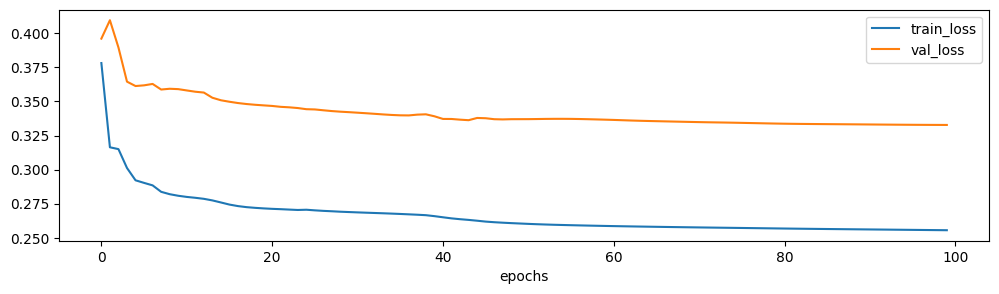

In [54]:
# sequence length = 4
train_loss_list, val_loss_list,lr_values,max_weights, max_grads,model_ae_lstm_path  = train_model_AE_LSTM(model_ae_lstm,loss_fn,100,train_loader,val_loader, learning_rate=1e-2)
# removed dropout -> mse 0.02
df = pd.DataFrame({'epochs':[i for i in range(100)],'train_loss': train_loss_list,'val_loss': val_loss_list})
df.plot(x="epochs", y=["train_loss", "val_loss"],kind="line")

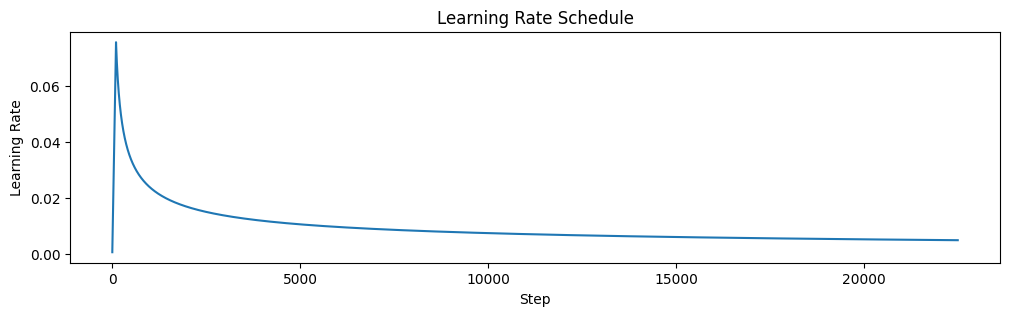

In [55]:
plt.plot(lr_values)
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.show()

# **Transformer Encoder Model**

In [103]:
class TST(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, Encoder,PositionalEncoding, N, d_model, d_input): ## layer = EncoderLayer
        super(TST, self).__init__()
        self.first_layer = nn.Linear(d_input, d_model)
        self.PE = PositionalEncoding
        self.Encoder = Encoder
        self.last_layer = nn.Linear(d_model, d_input)

    def forward(self, x, mask):
        "Pass the input through embedding and positional encoder and the output through a linear layer"
        x = self.first_layer(x)
        x = self.PE(x)
        x = self.Encoder(x,mask)
        x = self.last_layer(x)
        x = torch.sigmoid(x)
        return x

class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N): 
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)

    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return x

class LayerNorm(nn.Module):
    "Construct a layernorm module"
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        x = self.sublayer[0].forward(x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1].forward(x, self.feed_forward)

def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = scores.softmax(dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [
            lin(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
            for lin, x in zip(self.linears, (query, key, value))
        ]
        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(
            query, key, value, mask=mask, dropout=self.dropout
        )
        # 3) "Concat" using a view and apply a final linear.
        x = (
            x.transpose(1, 2)
            .contiguous()
            .view(nbatches, -1, self.h * self.d_k)
        )
        del query
        del key
        del value
        return self.linears[-1](x)

class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(self.w_1(x).relu()))


class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)

In [104]:
def make_model(d_input,N=6, d_model=128, d_ff=2048, h=8, dropout=0.5):
    "Helper: Construct a model from hyperparameters."
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    Encoder_model = Encoder(EncoderLayer(d_model, attn, ff, dropout), N)
    model = TST(Encoder_model,PositionalEncoding(d_model, dropout), N, d_model, d_input)
    # Initialize parameters with Xavier.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

## **Train TE model**

In [105]:
# Parameters
d_input = train.shape[1]

In [59]:
# Hyperparameters
## dimension of the embedding
d_model = 128
## dimension of the output of FF layer
d_ff = 64
## Number of Encoders
N = 3
## Number of heads
h = 8

In [116]:
# main loop (train+eval)
def main_loop(TS_model, loss_fn, epochs, train_loader, val_loader, learning_rate=learning_rate, gamma=0.9, d_ff=64,N=3,h=8):
    optimizer = torch.optim.Adam(TS_model.parameters(),lr = learning_rate)  
    scheduler = ExponentialLR(optimizer, gamma=gamma)
    model_opt = NoamOpt(d_input, 2, 20,
    torch.optim.Adam(TS_model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
    train_loss_list = []
    val_loss_list = []
    min_valid_loss = np.inf
    for epoch in range(epochs):
        train_loss = 0
        # training
        TS_model.train() # mode "train" agit sur "dropout" ou "batchnorm"
        for batch in train_loader:
            x, x_nan, mask = batch
            if torch.cuda.is_available():
                x, x_nan, mask = x.cuda(), x_nan.cuda(), mask.cuda()
            optimizer.zero_grad()
            out = TS_model(x_nan,None)
            loss = loss_fn(out, x,mask)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        #scheduler.step()
        # validation
        valid_loss = 0.0
        TS_model.eval() 
        with torch.no_grad():
            for batch in val_loader:
                x, x_nan, mask = batch
                if torch.cuda.is_available():
                    x, x_nan, mask = x.cuda(), x_nan.cuda(), mask.cuda()
                out = TS_model(x_nan,None)
                loss = loss_fn(out, x,mask)
                valid_loss += loss.item()
        if min_valid_loss > valid_loss:
            min_valid_loss = valid_loss
            # Saving State Dict
            date_time = datetime.datetime.now()
            index = ('_').join(str(date_time).split(' '))
            PATH = './trained_models/model_' + index
            torch.save({
            'epoch': epoch,
            'd_input':d_input,
            'N': N,
            'd_model':d_model,
            'd_ff': d_ff,
            'h': h,
            'dropout':dropout,
            'batch_size': batch_size,
            'learning_rate':learning_rate,
            'missing_ratio': missing_ratio,
            'model_state_dict': TS_model.state_dict()
            }, PATH)
        train_loss_list.append(train_loss / len(train_loader))
        val_loss_list.append(valid_loss/len(val_loader))
        print('Epoch {}: train loss: {}, val loss: {}'.format(epoch,train_loss / len(train_loader),valid_loss/len(val_loader)))
    # Saving State Dict
    date_time = datetime.datetime.now()
    index = ('_').join(str(date_time).split(' '))
    PATH = './trained_models/TS_models/model_final_' + index
    torch.save({
    'epoch': epochs,
    'd_input':d_input,
    'N': N,
    'd_model':d_model,
    'd_ff': d_ff,
    'h': h,
    'dropout':dropout,
    'batch_size': batch_size,
    'learning_rate':learning_rate,
    'missing_ratio': missing_ratio,
    'model_state_dict': TS_model.state_dict(),
    'train_loss': train_loss_list,
    'val_loss':val_loss_list
    }, PATH)
    clear_output()
    print('last model version path: ',PATH)
    return train_loss_list, val_loss_list,PATH

In [ ]:
NUM_TRIALS=20
d_model = 128

def objective(trial: optuna.Trial): 
    
## dimension of the output of FF layer
    d_ff_vals = [32,64]
    ## Number of Encoders
    N_vals = [2,3,4,5]
    ## Number of heads
    h_vals =[2,4,6, 8]
    learning_rate = trial.suggest_loguniform('learning_rate', low=LR_MIN, high=LR_CEIL)
    h = trial.suggest_categorical('h', h_vals)
    N = trial.suggest_categorical('N', N_vals)
    d_ff= trial.suggest_categorical('d_ff', d_ff_vals)
    num_train_epochs = trial.suggest_discrete_uniform('num_train_epochs', low=MIN_EPOCHS, high=MAX_EPOCHS,q=10)
    sequence_length = trial.suggest_discrete_uniform('sequence_length', MIN_SEQ_LEN, MAX_SEQ_LEN,q=12)
    batch_size = trial.suggest_categorical('batch_size', BATCH_VALUES)
    loss_parameter = trial.suggest_categorical('loss_parameter', LOSS_PARAMS_LIST)
    dropout = trial.suggest_discrete_uniform('dropout', MIN_DROPOUT, MAX_DROPOUT,q=0.1)  
    
    sequence_length=int(sequence_length)
    d_input = train.shape[1]
    batch_size=int(batch_size)
    num_train_epochs=int(num_train_epochs)
    
    print('sequence_length',sequence_length,'batch_size',batch_size,'num_train_epochs',num_train_epochs)
    TS_model = make_model(d_input=d_input, N=N, d_model=d_model, d_ff=d_ff, h=h, dropout=dropout)
    if torch.cuda.is_available():
        TS_model = TS_model.cuda()  
        
    train_dataset = TSImputationTrainDataset(train,sequence_length,missing_ratio)
    val_dataset = TSImputationTrainDataset(val,sequence_length,missing_ratio)
    test_dataset = TSImputationEvalDataset(test,test_nan,test_mask,sequence_length)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    print('total training batch number: {}'.format(len(train_loader)))
    print('total validation batch number: {}'.format(len(val_loader)))
    print('total test batch number: {}'.format(len(test_loader)))

    loss_fn = ORT_MIT_Loss(loss_parameter)
    
    train_loss_list, val_loss_list,TS_model_Path = main_loop(TS_model,loss_fn,num_train_epochs,train_loader,val_loader,learning_rate=learning_rate, d_ff=d_ff,N=N,h=h)
         
    return train_loss_list[-1]

study = optuna.create_study(study_name='deepl_finetune', direction='minimize') 
study.optimize(func=objective, n_trials=NUM_TRIALS)  

print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial
print('  Value: {:.5f}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2023-03-29 22:27:52,701] A new study created in memory with name: deepl_finetune


sequence_length 24 batch_size 64 num_train_epochs 60
total training batch number: 113
total validation batch number: 29
total test batch number: 3877
Epoch 0: train loss: 0.19340679309969316, val loss: 0.17158754656981928
Epoch 1: train loss: 0.13714708269637538, val loss: 0.10723416627026448
Epoch 2: train loss: 0.10630912649697355, val loss: 0.09598632002400119
Epoch 3: train loss: 0.0922654179424862, val loss: 0.08813426007473485
Epoch 4: train loss: 0.08374544797980642, val loss: 0.08241056218728135
Epoch 5: train loss: 0.077744110346161, val loss: 0.07829727384154633
Epoch 6: train loss: 0.07315669043796214, val loss: 0.07487509063969769
Epoch 7: train loss: 0.06943125885121423, val loss: 0.07174611298873033
Epoch 8: train loss: 0.06629212829021695, val loss: 0.06917430827391519
Epoch 9: train loss: 0.06357121965772157, val loss: 0.066712932273724
Epoch 10: train loss: 0.06116427017373364, val loss: 0.06442182667301573
Epoch 11: train loss: 0.0590445961635803, val loss: 0.06251364

In [61]:
# Init Model
TS_model = make_model(d_input=d_input, N=N, d_model=d_model, d_ff=d_ff, h=h, dropout=dropout)
if torch.cuda.is_available():
    TS_model = TS_model.cuda()


In [62]:
count_parameters(TS_model)

This model has  251335  parameter


251335

last model version path:  ./trained_models/TS_models/model_final_2023-03-28_22:34:46.098520


<Axes: xlabel='epochs'>

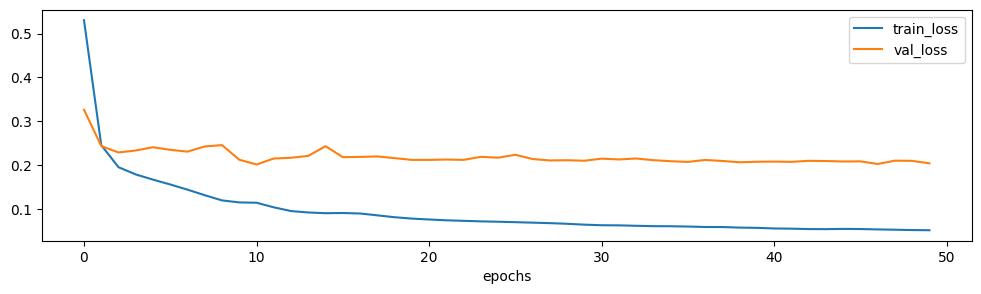

In [63]:
# sequence length = 4
train_loss_list, val_loss_list,TS_model_Path = main_loop(TS_model,loss_fn,epochs,train_loader,val_loader)
df = pd.DataFrame({'epochs':[i for i in range(epochs)],'train_loss': train_loss_list,'val_loss': val_loss_list})
df.plot(x="epochs", y=["train_loss", "val_loss"],kind="line")

# **Synthesis**

In [65]:
# AE model evaluation
model_ae=load_model(model_ae,model_ae_PATH) #get AE model
test_predicted, test_or = predict(model_ae, test,48,test_loader, is_flatten = True, is_TS = False )
mse_ae = evaluate_imputation_mse(test_or, test_predicted, test_mask,"AE")
t_test_ae = t_test(test_or, test_predicted, test_mask, "AE")
# AE_conv model eval

model_conv_ae=load_model(model_conv_ae,model_conv_ae_path) #get Conv_AE model
test_predicted, test_or = predict(model_conv_ae, test,48,test_loader, is_flatten = False, is_TS = False )
mse_conv_ae = evaluate_imputation_mse(test, test_predicted, test_mask,"Conv_autoencoder")
t_test_conv_ae = t_test(test_or, test_predicted, test_mask, "Conv_autoencoder")

# AE_LSTM model eval
model_ae_lstm=load_model(model_ae_lstm,model_ae_lstm_path) #get LSTM_AE model
test_predicted, test_or = predict(model_ae_lstm, test,48,test_loader, is_flatten = False, is_TS = False )
mse_lstm_ae = evaluate_imputation_mse(test, test_predicted, test_mask,"LSTM_autoencoder")
t_test_lstm_ae = t_test(test_or, test_predicted, test_mask, "LSTM_autoencoder")

# transformer model eval
 # _____________ get transformer model _______________________
model_path = TS_model_Path
info = torch.load(model_path)
model_TS = make_model(d_input=info['d_input'], N=info['N'], d_model=info['d_model'], d_ff=info['d_ff'], h=info['h'], dropout=info['dropout'])
model_TS=load_model(model_TS,model_path) #get LSTM_AE model
if torch.cuda.is_available():
    model_TS = model_TS.cuda()
#_____________________________________________________________
test_predicted, test_or = predict(model_TS, test,48,test_loader, is_flatten = False, is_TS = True )
mse_ts = evaluate_imputation_mse(test, test_predicted, test_mask,"Transformer_encoder")
t_test_ts  = t_test(test_or, test_predicted, test_mask, "Transformer_encoder")


--------------------
For  AE  the mse per column is: 
Global_active_power      0.001839
Global_reactive_power    0.001779
Voltage                  0.001506
Global_intensity         0.002299
Sub_metering_1           0.000674
Sub_metering_2           0.002915
Sub_metering_3           0.017617
dtype: float64
mse_mean  0.004089850154877012
--------------------
For  Conv_autoencoder  the mse per column is: 
Global_active_power      0.041648
Global_reactive_power    0.035199
Voltage                  0.288675
Global_intensity         0.037884
Sub_metering_1           0.005015
Sub_metering_2           0.016066
Sub_metering_3           0.217708
dtype: float64
mse_mean  0.09174225317484878
--------------------
For  LSTM_autoencoder  the mse per column is: 
Global_active_power      0.043029
Global_reactive_power    0.035422
Voltage                  0.289764
Global_intensity         0.040174
Sub_metering_1           0.005091
Sub_metering_2           0.016019
Sub_metering_3           0.232632
dtype

In [66]:
evaluations, tests_classique = evaluate_set(class_methods,test,test_nan,test_mask)
evaluations=pd.concat([evaluations,mse_ts,mse_lstm_ae,mse_ae,mse_conv_ae],axis=0)
evaluations = evaluations.sort_values(by=["mse"])
evaluations.reset_index(drop=True, inplace=True)
evaluations

--------------------
For  mean  the mse per column is: 
Global_active_power      0.023930
Global_reactive_power    0.014877
Voltage                  0.014104
Global_intensity         0.022556
Sub_metering_1           0.004737
Sub_metering_2           0.014978
Sub_metering_3           0.156451
dtype: float64
mse_mean  0.03594758651598736
--------------------
For  median  the mse per column is: 
Global_active_power      0.025356
Global_reactive_power    0.015654
Voltage                  0.014113
Global_intensity         0.024864
Sub_metering_1           0.005269
Sub_metering_2           0.016011
Sub_metering_3           0.221229
dtype: float64
mse_mean  0.04607086389152119
--------------------
For  mode  the mse per column is: 
Global_active_power      0.045514
Global_reactive_power    0.025967
Voltage                  0.014491
Global_intensity         0.044729
Sub_metering_1           0.005269
Sub_metering_2           0.016419
Sub_metering_3           0.273096
dtype: float64
mse_mean  0

,method,mse,var
0,AE,0.004090,0.000036
1,linear_interpolation,0.018414,0.000681
2,mice,0.019714,0.000893
3,NOCB,0.032284,0.002186
4,LOCF,0.032852,0.002281
5,spline_interpolation,0.035360,0.002865
6,mean,0.035948,0.002863
7,knn,0.036831,0.003173
8,median,0.046071,0.006012
9,mode,0.060784,0.008995


Text(0.5, 1.0, 'MSE evaluation of all approaches in test set')

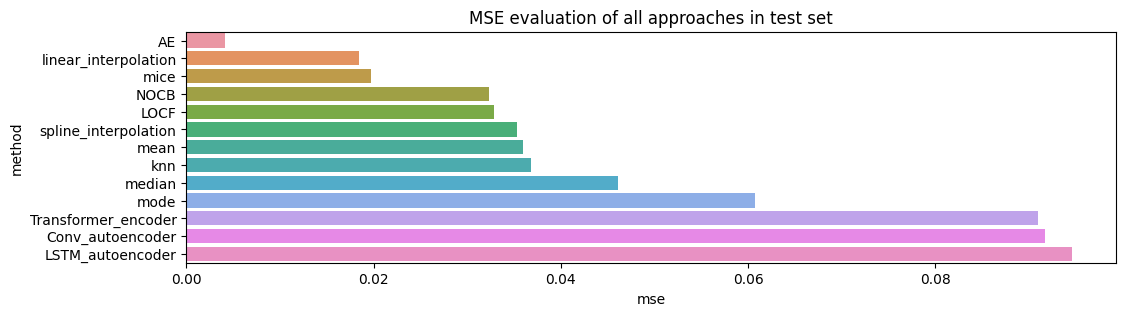

In [67]:
sns.barplot(x='mse',y='method',data=evaluations)
plt.title('MSE evaluation of all approaches in test set')

In [69]:
tests_classique=pd.concat([tests_classique,t_test_ae,t_test_lstm_ae,t_test_ts,t_test_conv_ae],axis=0)
tests_classique

,method,column,p-value,same_distribution
0,mean,Global_active_power,0.889896,False
1,mean,Global_reactive_power,0.548351,False
2,mean,Voltage,0.947904,False
3,mean,Global_intensity,0.385762,False
4,mean,Sub_metering_1,0.618196,False
...,...,...,...,...
2,Conv_autoencoder,Voltage,0.978429,False
3,Conv_autoencoder,Global_intensity,0.692393,False
4,Conv_autoencoder,Sub_metering_1,0.857338,False
5,Conv_autoencoder,Sub_metering_2,0.572035,False


In [70]:
tests_classique[tests_classique.method == "Conv_autoencoder"]

,method,column,p-value,same_distribution
0,Conv_autoencoder,Global_active_power,0.959512,False
1,Conv_autoencoder,Global_reactive_power,0.042954,True
2,Conv_autoencoder,Voltage,0.978429,False
3,Conv_autoencoder,Global_intensity,0.692393,False
4,Conv_autoencoder,Sub_metering_1,0.857338,False
5,Conv_autoencoder,Sub_metering_2,0.572035,False
6,Conv_autoencoder,Sub_metering_3,0.665714,False
0,Conv_autoencoder,Global_active_power,0.959512,False
1,Conv_autoencoder,Global_reactive_power,0.042954,True
2,Conv_autoencoder,Voltage,0.978429,False


In [71]:
tests_classique["same_distribution"] = tests_classique["same_distribution"].astype(int)
tests_classique.drop(['column','p-value'],axis = 1,inplace=True)
tests_classique = tests_classique.groupby(['method'],as_index=False).sum()
tests_classique

,method,same_distribution
0,AE,0
1,Conv_autoencoder,2
2,LOCF,0
3,LSTM_autoencoder,2
4,NOCB,0
5,Transformer_encoder,0
6,knn,3
7,linear_interpolation,0
8,mean,0
9,median,6


In [72]:
tests_classique = tests_classique.sort_values(by=["same_distribution"],ascending=False)

Text(0.5, 1.0, 'total number of features with same distribution after imputation')

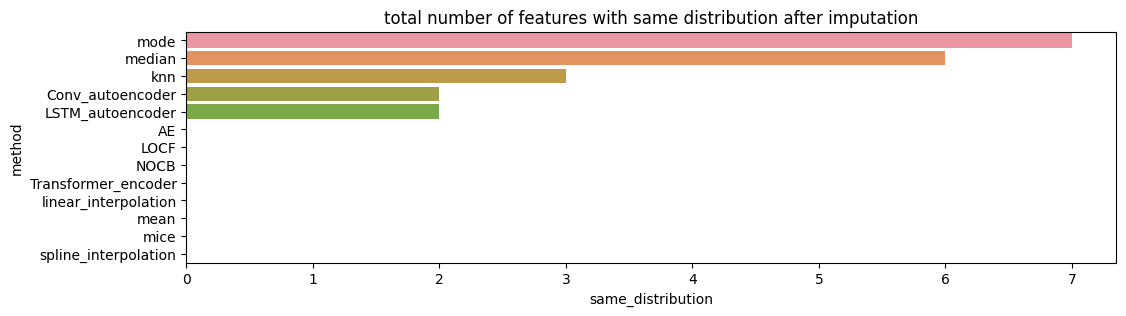

In [73]:
sns.barplot(x='same_distribution',y='method',data=tests_classique)
plt.title("total number of features with same distribution after imputation")